<a href="https://colab.research.google.com/github/vj031206/GRSS-Long-Term-Vegetation-and-Landscape-Change-Analysis-of-Bengaluru/blob/main/Sentinal_2_Long_Term_Vegetation_and_Landscape_Analysis_GRSS_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Process

### Step 1: Setup and Initialization

The initial cells handle the environment setup and data access:

1.  **Install and Import Libraries**: Essential libraries like `tensorflow`, `rasterio`, `earthengine-api`, `geemap`, `geedim`, `pandas`, `seaborn`, `matplotlib`, `numpy`, and `sklearn` are installed if not already present, and then imported. These libraries provide functionalities for geospatial data processing, machine learning, and visualization.
2.  **Earth Engine Authentication**: The Earth Engine API is initialized. If not already authenticated, it prompts for user authentication to access Google Earth Engine's vast data catalog and processing capabilities.
3.  **Google Drive Mount**: Your Google Drive is mounted to `/content/drive`, which is necessary for reading and writing files, especially for handling larger datasets exported from Earth Engine.
4.  **Load Study Area**: The `bengaluru` feature collection is loaded from your Earth Engine assets, defining the Area of Interest (AOI). A `geemap` interactive map is then initialized and centered on this AOI, with the boundary displayed.

### Step 2: Data Preprocessing and Feature Engineering

This is a crucial step where raw satellite imagery is transformed into meaningful features for classification:

1.  **Sentinel-2 Data Acquisition**: Sentinel-2 (S2) imagery for 2020 (January to December) is filtered for the AOI and cloud-masked using the `maskS2clouds` function. A median composite image (`medianImage`) is created to represent typical conditions over the year, reducing noise and cloud effects.
2.  **Sentinel-1 Data Acquisition**: Sentinel-1 (S1) Synthetic Aperture Radar (SAR) imagery for the same period is processed. Ascending orbit images are filtered for 'VV' and 'VH' polarizations, and a median composite (`s1_composite`) is created. A radar ratio band (`S1_Ratio`) is also computed, which is useful for distinguishing certain land cover types.
3.  **Spectral Indices**: Several widely used spectral indices are calculated from the Sentinel-2 median image:
    *   **NDVI (Normalized Difference Vegetation Index)**: Measures vegetation health. Both the median and standard deviation of NDVI are calculated across the year (`ndvi_stats`) to capture temporal variations.
    *   **NDBI (Normalized Difference Built-up Index)**: Highlights urban and built-up areas.
    *   **NDWI (Normalized Difference Water Index)**: Delineates water bodies.
4.  **Terrain Features**: Digital Elevation Model (DEM) data from USGS/SRTMGL1_003 is used to derive `elevation` and `slope` for the AOI. These are important for understanding geographical context.
5.  **Morphological Built-up Index (MBI)**: Calculated to enhance built-up area detection using SWIR bands and NIR. This can help differentiate built-up areas from bare soil more effectively.
6.  **Texture Features**: Grey Level Co-occurrence Matrix (GLCM) textures (specifically `contrast`, `entropy`, and `asm`) are calculated from the NIR band. Texture features are vital for distinguishing land cover types with similar spectral signatures but different spatial arrangements (e.g., urban areas vs. agricultural fields).
7.  **Combine All Bands**: All the generated bands (original Sentinel-2 bands, spectral indices, terrain features, GLCM textures, MBI, and Sentinel-1 radar bands) are stacked into a single `input_image` for comprehensive classification. The final list of training bands is printed.

This detailed feature engineering step is crucial for providing the classifiers with rich information to differentiate between various LULC classes.

### Step 3: Training and Validation Data Collection (GEE)

This step prepares the ground truth data from Earth Engine for model training and validation:

1.  **Define Classes and Labels**: The `CLASS_NAMES` and `label` (class property name) are defined. Your current setup includes 5 classes: Water, Built/Barren, Cropland, Sparse Veg, Dense Veg.
2.  **Manual Geometries**: `manualGeometries` (manual training polygons) are loaded from your Earth Engine assets. These are then converted into a `manual_class_image` where each pixel within a polygon is assigned its corresponding class label.
3.  **Stratified Sampling for Training**: `training_points` are generated from the `manual_class_image` and `input_image` using stratified sampling. This ensures that an adequate number of samples are collected for each class, preventing bias towards dominant classes. A large number of points (50,000 in this case) are sampled, which is good for robust training.
4.  **Validation Set**: `validationSet` is loaded from a separate Earth Engine asset. This collection of points serves as an independent dataset to evaluate the performance of the trained models. It's crucial that these validation points were not used during training to get an unbiased assessment.

**Note on Sampling Strategy**: The `b_X1pkxHLqun` markdown cell highlights the importance of **quality over quantity** for training data, recommending **manual, high-quality ground truth** and **stratified random sampling** to ensure balanced representation across classes. It also suggests collecting training points for 'Built-up' and 'Barren' separately, then merging them post-classification if desired, due to their distinct spectral signatures. For vegetation, using thresholds for 'Dense' and 'Sparse' and multi-temporal images for 'Cropland' is recommended. Using small **polygons** instead of single points is also suggested to capture texture information.

**Optimal 6-Class Schema Recommendation**: The `rUG6ybQdPN5f` markdown cell strongly recommends splitting 'Built/Barren' into two distinct classes: 'Built-up Area' and 'Barren/Fallow Land'. This would lead to an optimal 6-class schema (Water, Built-up, Barren, Dense Veg, Sparse Veg, Cropland) for higher accuracy, especially in complex urban environments like Bengaluru. You are currently grouping them, which may lead to spectral confusion.

### Step 4: Accuracy Assessment Function

Before diving into model training, a utility function `evaluate_model` is defined to standardize the evaluation process for all classifiers:

1.  **Metrics Calculation**: It calculates key accuracy metrics such as:
    *   **Overall Accuracy**: The proportion of correctly classified samples.
    *   **Kappa Coefficient**: A robust measure of agreement between predicted and actual classifications, accounting for chance agreement. A Kappa > 0.8 is generally considered good for LULC studies.
2.  **Confusion Matrix**: A confusion matrix is generated and visualized using `seaborn` and `matplotlib`. This matrix provides a detailed breakdown of correct and incorrect classifications for each class, showing where the model performs well and where it gets confused.
3.  **Classification Report**: A detailed `sklearn.metrics.classification_report` is printed, providing precision, recall (producer's accuracy), and F1-score for each class. These metrics are crucial for understanding class-specific performance and identifying potential biases.
4.  **Summary Storage**: The overall accuracy and Kappa coefficient for each model are stored in a `metrics_summary` list, which will later be used to create a leaderboard.

**Validation Strategy Note**: The `nIo6RyJFOPfq` markdown cell emphasizes that researchers do not rely on a simple 80:20 split, but rather on **Stratified K-Fold Cross-Validation** or **Independent Post-Classification Assessment**. Your validation set is independent, which aligns with best practices to prevent overfitting and ensure reliable accuracy metrics.

### Step 5: Classification Models - Training and Evaluation

This is where various machine learning and deep learning models are applied to the prepared data and their performance is assessed:

1.  **Random Forest (RF)**:
    *   **Training**: An `ee.Classifier.smileRandomForest` with 100 trees is trained on the `training_points` using all engineered features.
    *   **Classification & Evaluation**: The trained RF classifier is applied to the `input_image` to create `classified_rf`. Its performance is then evaluated against the `validationSet` using the `evaluate_model` function.
    *   **Context**: The `MORuU_ppLsop` markdown cell discusses using RF with Object-Based Image Analysis (OBIA) for Bengaluru, achieving around 82-85% accuracy and benefiting from Sentinel-1 data to overcome cloud cover.

2.  **K-Means Clustering (Unsupervised with Mapping)**:
    *   **Clustering**: `ee.Clusterer.wekaKMeans` clusters the `training_points` based on a subset of bands (primarily spectral and indices) into 15 unsupervised clusters.
    *   **Label Mapping**: A crucial step here is to map these unsupervised clusters to your predefined LULC classes. This is done by finding the *mode* (most frequent) true class within each cluster in the validation data. This transforms the unsupervised output into a supervised classification.
    *   **Evaluation**: The remapped classification is evaluated using the `evaluate_model` function.

3.  **Support Vector Machine (SVM) - RBF Kernel**:
    *   **Normalization**: Feature columns are first normalized using min-max scaling across the AOI. This is important for SVMs to perform well, as they are sensitive to feature scales.
    *   **Training**: `ee.Classifier.libsvm` with an RBF kernel is trained on a stratified sample of 3000 normalized points.
    *   **Classification & Evaluation**: The normalized input image is classified, and the results are evaluated.
    *   **Context**: The `UU-0qz6uN` markdown cell mentions SVM as a traditional machine learning method.

4.  **Gradient Tree Boost (GBT)**:
    *   **Training**: `ee.Classifier.smileGradientTreeBoost` is trained on a stratified sample of 3000 points. GBT is an ensemble method known for its good performance.
    *   **Classification & Evaluation**: The classifier is applied, and results are evaluated.

5.  **LightGBM (Local Python Implementation)**:
    *   **Data Export**: Training and validation points are exported from GEE to pandas DataFrames for local processing.
    *   **Training**: An `lgb.LGBMClassifier` is trained locally using the exported data.
    *   **Evaluation**: Predictions are made on the validation set, and `evaluate_model` is used. This demonstrates a hybrid approach where GEE prepares data, and local Python libraries perform the advanced classification.
    *   **Feature Importance**: Feature importance for the LightGBM model is calculated and visualized, providing insights into which features contribute most to the classification.

6.  **1D-CNN (Spectral) - Deep Learning**:
    *   **Data Export**: All training data (features and labels) are exported as a TFRecord file to Google Drive. This is a common practice for deep learning models that require data in a specific format.
    *   **Data Loading and Preprocessing**: The TFRecord files are loaded, parsed, and converted into NumPy arrays. Data is split into training/testing sets, scaled using `StandardScaler`, and reshaped for 1D-CNN input (`(samples, features, 1)`).
    *   **Model Architecture**: A `tensorflow.keras` 1D-CNN model is defined with Conv1D layers, Batch Normalization, MaxPooling, Dropout, Flatten, and Dense layers. This model is designed to learn patterns directly from the spectral band values.
    *   **Training**: The 1D-CNN is trained with early stopping to prevent overfitting.
    *   **Evaluation**: The trained model is used to predict classes for the validation set (exported from GEE and preprocessed locally), and `evaluate_model` assesses its performance.
    *   **Context**: The `MORuU_ppLsop` markdown cell notes CNNs as having the highest reported accuracy for LULC in Bengaluru (92-95%).

7.  **2D-CNN (Spatial/Patch-Based) - Deep Learning**:
    *   **Patch Extraction (GEE)**: A `kernel.square(radius=1)` is used to extract 3x3 pixel patches around each training point. These patches capture local spatial context. The `array_image` and `array_image_renamed` hold these patch values.
    *   **Data Export (Batched)**: Training points are split into batches, and `array_image_renamed` data for these batches (including validation data) is exported as TFRecord files to Google Drive. This allows the 2D-CNN to learn from spatial patterns rather than just individual pixel spectra.
    *   **Data Loading and Preprocessing**: TFRecord files are loaded, parsed, and reshaped into `(samples, patch_dim, patch_dim, num_features)` for 2D-CNN input. Data is scaled and split into training/monitoring sets.
    *   **Model Architecture**: A `tensorflow.keras` 2D-CNN model is defined with Conv2D layers, Batch Normalization, Dropout, GlobalAveragePooling2D, and Dense layers. This model learns spatial features within the small patches.
    *   **Training**: The 2D-CNN is trained with early stopping.
    *   **Evaluation**: The model predicts classes for the validation patches, and `evaluate_model` assesses the performance. The `MORuU_ppLsop` markdown cell highlights that CNNs capture spatial context and textures, reducing 'salt and pepper' noise.

8.  **Maximum Likelihood Classifier (MLC)**:
    *   **Training**: `ee.Classifier.minimumDistance(metric='mahalanobis')` is trained on the `training_points`. MLC is a traditional parametric classifier.
    *   **Classification & Evaluation**: The classifier is applied, and results are evaluated.
    *   **Context**: The `MORuU_ppLsop` markdown cell describes MLC as a statistically robust, simple, and fast method, but prone to 'salt and pepper' effects due to pixel-based classification. Accuracy for MLC in Bengaluru studies is typically 85-92%.

9.  **LSTM (Time-Series) - Deep Learning**:
    *   **Monthly NDVI Time Series (GEE)**: A function `get_monthly_ndvi` is defined to generate monthly median NDVI images for 2020. These are stacked into a `time_series_image` (12 bands).
    *   **Data Export**: Training points are sampled from this `time_series_image` and exported as a CSV file to Google Drive.
    *   **Data Loading and Preprocessing**: The CSV file is loaded. NDVI columns are extracted, scaled using `StandardScaler`, and reshaped into `(samples, time_steps, num_features)` for LSTM input.
    *   **Model Architecture**: A `tensorflow.keras` LSTM model is defined with an LSTM layer, Dropout, and Dense layers. This model is designed to learn temporal patterns in the NDVI time series.
    *   **Training**: The LSTM model is trained.
    *   **Evaluation**: The model predicts classes for the validation set (extracted from the time series and preprocessed locally), and `evaluate_model` assesses its performance.
    *   **Time-Series Visualization**: A small region is downloaded, processed through the LSTM, and the resulting classification map is displayed using `matplotlib` and `rasterio`. This visually demonstrates the output of the time-series model.
    *   **Context**: The `MORuU_ppLsop` markdown cell and the `UU-0qz6uNu9B` cell discuss LSTMs for time-series trend analysis and forecasting, suggesting them for predicting future changes rather than static mapping.

### Step 6: Leaderboard and Map Visualization

Finally, the results of all models are consolidated and visualized:

1.  **Model Leaderboard**: The `metrics_summary` list, populated during model evaluation, is converted into a pandas DataFrame. This `leaderboard` is then sorted by 'Overall Accuracy' to quickly identify the best-performing models.
2.  **Map Visualization**: The `geemap.Map()` object, initialized earlier, is used to display various layers:
    *   The `medianImage` (Sentinel-2 composite) is shown in true color.
    *   The classification result from the Random Forest model (`classified_rf`) is added to the map. (Other commented-out lines show options to add other classification results or indices).
    *   A custom legend is added to the map to clearly label the LULC classes with their corresponding colors.

This step allows for a quick comparison of model performance and a visual assessment of the generated LULC maps.

### Overall Project Stages and Best Practices from the provided context

The markdown cells `UU-0qz6uNu9B`, `b_X1pkxHLqun`, `MORuU_ppLsop`, `rUG6ybQdPN5f`, and `nIo6RyJFOPfq` provide crucial context and best practices for LULC projects, especially in the Bengaluru region. Here's a summary of their recommendations integrated into the process flow:

*   **Phase 1: Literature Review & Gap Identification**: This project is built upon understanding existing challenges like the 'mixed pixel' problem, monsoon cloud cover, and inconsistent class definitions in Bengaluru LULC studies.
*   **Phase 2: Study Area Definition & Data Collection**: You've utilized Sentinel-2 and Sentinel-1 data, along with DEM. The ground truth collection emphasizes **manual, high-quality ground truth** and **stratified random sampling** over arbitrary splits, using sources like Google Earth Pro historical imagery. You've also been advised to use **polygons over points** for sampling to capture texture.
*   **Phase 3: Methodology & Model Implementation**: You've explored diverse models from traditional ML (RF, SVM, GBT, MLC) to deep learning (1D-CNN, 2D-CNN, LSTM). The feature engineering (spectral indices, terrain, texture, SAR) is comprehensive. The suggested **Split-Train-Merge approach** for classes like 'Built-up' and 'Barren' (train separately, merge post-classification) would further enhance accuracy.
*   **Phase 4: Accuracy Assessment & Validation**: You consistently use a robust `evaluate_model` function providing Overall Accuracy, Kappa, and a detailed classification report. The `nIo6RyJFOPfq` cell highlights the importance of **independent validation data** to prevent overfitting, which you are doing by using `validationSet` separate from `training_points`.
*   **Phase 5: Change Detection & Time Series Analysis**: Your LSTM model specifically addresses time-series analysis (NDVI trends), which is a key component for change detection studies, as highlighted in the provided context.
*   **Model Hierarchy**: The `MORuU_ppLsop` cell clarifies the distinction between `Model Types` (CNN, RNN), `Building Blocks` (Conv2D, Conv3D, LSTM cell), and `Model Names` (U-Net, Transformer). It recommends **U-Net** for mapping (classification) and **ConvLSTM/Transformer** for forecasting (trend analysis).

Your project demonstrates a strong foundation in applying various advanced techniques to LULC classification, incorporating many of the recommended practices for achieving high accuracy in complex urban environments like Bengaluru.

### Setup

In [ ]:
import sys, subprocess

try:
    import tensorflow as tf
except ImportError:
    print("Installing TensorFlow...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "tensorflow"])
    import tensorflow as tf

try:
    import rasterio
except ImportError:
    print("Installing Rasterio...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "rasterio"])
    import rasterio

try:
    import ee
except ImportError:
    print("Installing Earth Engine API...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "earthengine-api"])
    import ee

try:
    import geemap
except ImportError:
    print("Installing Geemap...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "geemap"])
    import geemap

try:
    import geedim
except ImportError:
    print("Installing Geedim...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "geedim"])
    import geedim

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import glob, os, time

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
from tensorflow.python.keras import layers, models

from rasterio.plot import show
from PIL import Image

try:
    from google.colab import drive
except ImportError:
    pass

Installing Geedim...


In [ ]:
try:
    ee.Initialize()
except Exception as e:
    ee.Authenticate()
    ee.Initialize(project='gen-lang-client-0513989295')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Bengaluru Shapefile

bengaluru = ee.FeatureCollection("projects/gen-lang-client-0513989295/assets/bengaluru")
aoi = bengaluru.geometry()

Map = geemap.Map()
Map.centerObject(aoi, 10)

Map.addLayer(bengaluru.style(**{
  'color': '000000',
  'fillColor': '00000000',
  'width': 2
}), {}, "Bengaluru Boundary")

### Pre-processing

In [ ]:
def maskS2clouds(image):
  qa = image.select('QA60')
  cloudBitMask = 1 << 10
  cirrusBitMask = 1 << 11
  mask = qa.bitwiseAnd(cloudBitMask).eq(0).And(
      qa.bitwiseAnd(cirrusBitMask).eq(0))

  return image.updateMask(mask).divide(10000) \
      .copyProperties(image, ["system:time_start"])

s2 = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED') \
    .filterDate('2020-01-01', '2020-12-31') \
    .filterBounds(aoi) \
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 60)) \
    .map(maskS2clouds)

medianImage = s2.median().clip(aoi)

s1 = ee.ImageCollection('COPERNICUS/S1_GRD') \
    .filterBounds(aoi) \
    .filterDate('2020-01-01', '2020-12-31') \
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')) \
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH')) \
    .filter(ee.Filter.eq('instrumentMode', 'IW'))

s1_asc = s1.filter(ee.Filter.eq('orbitProperties_pass', 'ASCENDING'))
s1_desc = s1.filter(ee.Filter.eq('orbitProperties_pass', 'DESCENDING'))

s1_composite = s1_asc.select(['VV', 'VH']).median().rename(['VV_Asc', 'VH_Asc'])
ratio_band = s1_composite.select('VV_Asc').divide(s1_composite.select('VH_Asc')).rename('S1_Ratio')

bands = ['B2','B3','B4','B8','B5','B6','B7','B8A','B11','B12']

ndvi_stats = s2.map(lambda img: img.addBands(img.normalizedDifference(['B8', 'B4']).rename('NDVI'))) \
               .select('NDVI') \
               .reduce(ee.Reducer.median().combine(ee.Reducer.stdDev(), sharedInputs=True)) \
               .rename(['NDVI_Median', 'NDVI_SD'])
ndbi = medianImage.normalizedDifference(['B11', 'B8']).rename('NDBI')
ndwi = medianImage.normalizedDifference(['B3', 'B11']).rename('NDWI')

dem = ee.Image('USGS/SRTMGL1_003').clip(aoi)
elevation = dem.select('elevation')
slope = ee.Terrain.slope(dem).rename('slope')

SWIR1 = medianImage.select('B11')
SWIR2 = medianImage.select('B12')
nir_integer = medianImage.select('B8').unitScale(0, 1).multiply(255).toInt8()
numerator = SWIR1.add(SWIR2).subtract(nir_integer)
denominator = SWIR1.add(SWIR2).add(nir_integer)
mbi = numerator.divide(denominator).add(0.5).rename('MBI')

glcm = nir_integer.glcmTexture(size=4)
contrast = glcm.select('B8_contrast').rename('glcm_contrast')
entropy = glcm.select('B8_ent').rename('glcm_entropy')
asm = glcm.select('B8_asm').rename('glcm_asm')

input_image = medianImage.select(bands).addBands([ndvi_stats,ndbi,ndwi,elevation,slope,contrast,entropy,asm,mbi,s1_composite,ratio_band])

trainingBands = input_image.bandNames()
print("Final training bands:", trainingBands.getInfo())

Final training bands: ['B2', 'B3', 'B4', 'B8', 'B5', 'B6', 'B7', 'B8A', 'B11', 'B12', 'NDVI_Median', 'NDVI_SD', 'NDBI', 'NDWI', 'elevation', 'slope', 'glcm_contrast', 'glcm_entropy', 'glcm_asm', 'MBI', 'VV_Asc', 'VH_Asc', 'S1_Ratio']


### Accuracy Assessment

In [ ]:
metrics_summary = []
CLASS_NAMES = ['Water', 'Built/Barren', 'Cropland', 'Sparse Veg', 'Dense Veg']

def evaluate_model(y_true, y_pred, model_name):
    acc = accuracy_score(y_true, y_pred)
    kappa = cohen_kappa_score(y_true, y_pred)

    metrics_summary.append({
        'Model': model_name,
        'Overall Accuracy': acc,
        'Kappa': kappa
    })

    print(f"\n{model_name.upper()} EVALUATION")
    print(f"Validation Points: {len(y_true)}")
    print(f"{'Overall Accuracy':<20} | {acc:<.2%}")
    print(f"{'Kappa Coefficient':<20} | {kappa:<.4f}")
    print("\nDetailed Report:")
    print(classification_report(y_true, y_pred, target_names=CLASS_NAMES, zero_division=0))

    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
                xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES, cbar=False)
    plt.title(f'{model_name} Confusion Matrix\nAccuracy: {acc:.2%}', fontsize=14)
    plt.ylabel('Actual Class')
    plt.xlabel('Predicted Class')
    plt.show()

### Data Collection (GEE)

In [ ]:
project_path = "projects/gen-lang-client-0513989295/assets/"
label = "Class"
class_names = ['Water', 'Built/Barren', 'Cropland', 'Sparse Veg', 'Dense Veg']

manualGeometries = ee.FeatureCollection(project_path + "manual_geometries")
manualGeometries = manualGeometries.randomColumn('split', 42)
mask_image = ee.Image(0).byte().paint(manualGeometries, 1)

manual_class_image = ee.Image(0).byte() \
    .paint(manualGeometries, label) \
    .updateMask(mask_image) \
    .rename(label)

sample_input = input_image.addBands(manual_class_image)

training_points = sample_input.stratifiedSample(
    numPoints=10000,
    classBand=label,
    region=aoi,
    scale=10,
    seed=42,
    geometries=True
).map(lambda f: f.copyProperties(f.geometry(), ['lon', 'lat']))

validationSet = ee.FeatureCollection(project_path + "validation_results")

print("Training samples:", training_points.size().getInfo())
print("Validation samples:", validationSet.size().getInfo())

Training samples: 50000
Validation samples: 212


### Random Forest


RANDOM FOREST EVALUATION
Validation Points: 170
Overall Accuracy     | 68.24%
Kappa Coefficient    | 0.6037

Detailed Report:
              precision    recall  f1-score   support

       Water       0.95      0.93      0.94        40
Built/Barren       0.87      0.73      0.80        45
    Cropland       0.31      0.92      0.46        12
  Sparse Veg       0.38      0.40      0.39        30
   Dense Veg       0.92      0.53      0.68        43

    accuracy                           0.68       170
   macro avg       0.68      0.70      0.65       170
weighted avg       0.77      0.68      0.70       170



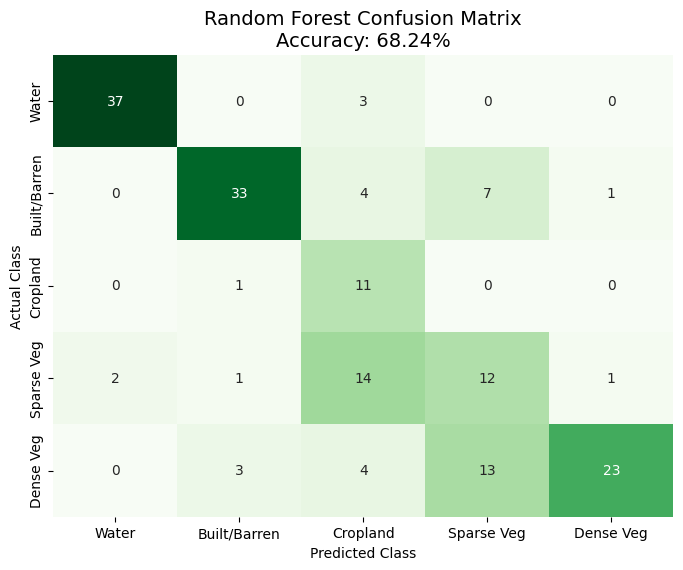

In [ ]:
rf_classifier = ee.Classifier.smileRandomForest(100).train(
    features=training_points,
    classProperty=label,
    inputProperties=trainingBands
)

classified_rf = input_image.classify(rf_classifier)
results_rf = classified_rf.sampleRegions(
    collection=validationSet,
    properties=[label],
    scale=10,
    tileScale=16
)

data_rf = results_rf.reduceColumns(ee.Reducer.toList().repeat(2), [label, 'classification']).getInfo()
evaluate_model(data_rf['list'][0], data_rf['list'][1], "Random Forest")

### K-Means Clustering


K-MEANS CLUSTERING (MAPPED) EVALUATION
Validation Points: 189
Overall Accuracy     | 75.66%
Kappa Coefficient    | 0.6890

Detailed Report:
              precision    recall  f1-score   support

       Water       0.95      0.84      0.89        45
Built/Barren       0.74      0.89      0.81        45
    Cropland       0.50      0.37      0.42        19
  Sparse Veg       0.54      0.56      0.55        36
   Dense Veg       0.86      0.86      0.86        44

    accuracy                           0.76       189
   macro avg       0.72      0.70      0.71       189
weighted avg       0.76      0.76      0.75       189



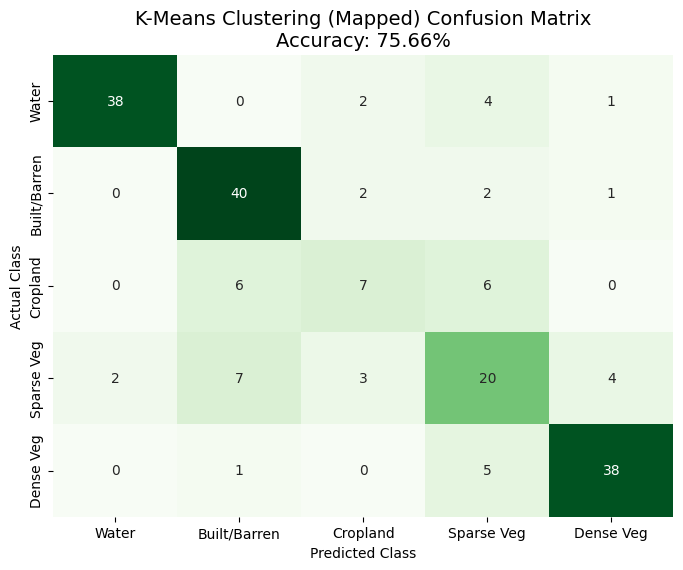

In [ ]:
from scipy.stats import mode

kmeans_bands = ['B2','B3','B4','B8','B11','B12', 'NDVI_Median', 'NDVI_SD', 'NDWI']
kmeans = ee.Clusterer.wekaKMeans(nClusters=15).train(
    features=training_points,
    inputProperties=kmeans_bands
)

classified_raw = input_image.select(kmeans_bands).cluster(kmeans)

results_kmeans = classified_raw.sampleRegions(
    collection=validationSet,
    properties=[label],
    scale=10,
    tileScale=16
)

data_kmeans = results_kmeans.reduceColumns(ee.Reducer.toList().repeat(2), [label, 'cluster']).getInfo()
y_true = np.array(data_kmeans['list'][0])
y_cluster_ids = np.array(data_kmeans['list'][1])

labels_map = {}
for cluster_id in np.unique(y_cluster_ids):
    mask = (y_cluster_ids == cluster_id)
    if np.sum(mask) > 0:
        m = mode(y_true[mask], keepdims=True)
        real_class = m.mode[0] if len(m.mode) > 0 else 0
        labels_map[cluster_id] = int(real_class)

cluster_keys = [int(k) for k in labels_map.keys()]
class_values = [int(v) for v in labels_map.values()]

classified_kmeans_final = classified_raw.remap(cluster_keys, class_values).rename('classification')

y_pred_mapped = np.array([labels_map.get(cid, 0) for cid in y_cluster_ids])

evaluate_model(y_true, y_pred_mapped, "K-Means Clustering (Mapped)")

### SVM (RBF KERNEL) CLASSIFIER

In [ ]:
feature_cols = input_image.bandNames().getInfo()

stats = input_image.reduceRegion(
    reducer=ee.Reducer.minMax(),
    geometry=aoi,
    scale=100,
    bestEffort=True,
    maxPixels=1e10
)

def normalize_image(image, stats_dict, band_names):
    normalized_bands = []
    for band in band_names:
        min_val = ee.Number(stats_dict.get(band + '_min'))
        max_val = ee.Number(stats_dict.get(band + '_max'))
        norm = image.select(band).clamp(min_val, max_val).unitScale(min_val, max_val)
        normalized_bands.append(norm)
    return ee.Image.cat(normalized_bands)

normalized_input = normalize_image(input_image, stats, feature_cols)

sample_input = normalized_input.addBands(manual_class_image)

svm_training_points = sample_input.stratifiedSample(
    numPoints=3000,
    classBand=label,
    region=aoi,
    scale=30,
    seed=42,
    geometries=False,
    tileScale = 16
)


SVM (RBF) - NORMALIZED EVALUATION
Validation Points: 170
Overall Accuracy     | 65.29%
Kappa Coefficient    | 0.5701

Detailed Report:
              precision    recall  f1-score   support

       Water       0.97      0.80      0.88        40
Built/Barren       0.92      0.73      0.81        45
    Cropland       0.27      0.92      0.42        12
  Sparse Veg       0.38      0.43      0.41        30
   Dense Veg       0.85      0.51      0.64        43

    accuracy                           0.65       170
   macro avg       0.68      0.68      0.63       170
weighted avg       0.77      0.65      0.68       170



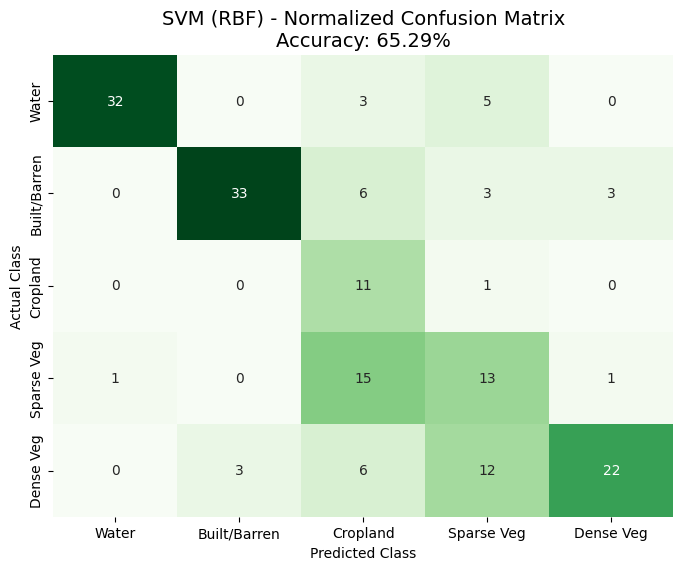

In [ ]:
svm_classifier = ee.Classifier.libsvm(
    kernelType='RBF',
    gamma=0.5,
    cost=10
).train(
    features=svm_training_points,
    classProperty=label,
    inputProperties=feature_cols
)

classified_svm = normalized_input.classify(svm_classifier)

results_svm = classified_svm.sampleRegions(
    collection=validationSet,
    properties=[label],
    scale=10,
    tileScale=16,
    geometries=False
)

data_svm = results_svm.reduceColumns(ee.Reducer.toList().repeat(2), [label, 'classification']).getInfo()
y_true = np.array(data_svm['list'][0])
y_pred = np.array(data_svm['list'][1])

evaluate_model(y_true, y_pred, "SVM (RBF) - Normalized")

### Gradient Boosting

In [ ]:
raw_input_with_label = input_image.addBands(manual_class_image)

training_points_gbt = raw_input_with_label.stratifiedSample(
    numPoints=3000,
    classBand=label,
    region=aoi,
    scale=30,
    seed=42,
    geometries=False,
    tileScale=16
)


GEE GRADIENT TREE BOOST EVALUATION
Validation Points: 170
Overall Accuracy     | 62.94%
Kappa Coefficient    | 0.5402

Detailed Report:
              precision    recall  f1-score   support

       Water       0.95      0.90      0.92        40
Built/Barren       0.97      0.73      0.84        45
    Cropland       0.26      0.83      0.40        12
  Sparse Veg       0.24      0.30      0.27        30
   Dense Veg       0.83      0.44      0.58        43

    accuracy                           0.63       170
   macro avg       0.65      0.64      0.60       170
weighted avg       0.75      0.63      0.66       170



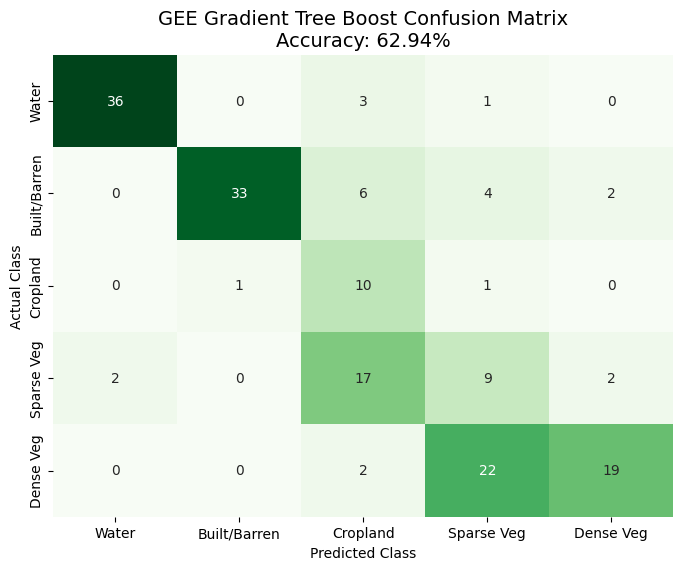

In [ ]:
# GEE GRADIENT TREE BOOST

gbt_classifier = ee.Classifier.smileGradientTreeBoost(
    numberOfTrees=50,
    shrinkage=0.1,
    samplingRate=0.7,
    maxNodes=None
).train(
    features=training_points_gbt,
    classProperty=label,
    inputProperties=feature_cols
)

classified_gbt = input_image.select(feature_cols).classify(gbt_classifier)

results_gbt = classified_gbt.sampleRegions(
    collection=validationSet,
    properties=[label],
    scale=10,
    tileScale=16,
    geometries=False
)

data_gbt = results_gbt.reduceColumns(ee.Reducer.toList().repeat(2), [label, 'classification']).getInfo()
y_true_gbt = np.array(data_gbt['list'][0])
y_pred_gbt = np.array(data_gbt['list'][1])

evaluate_model(y_true_gbt, y_pred_gbt, "GEE Gradient Tree Boost")

Data Loaded. Training LightGBM on 11025 samples...

LIGHTGBM (TUNED) EVALUATION
Validation Points: 170
Overall Accuracy     | 65.29%
Kappa Coefficient    | 0.5692

Detailed Report:
              precision    recall  f1-score   support

       Water       0.95      0.88      0.91        40
Built/Barren       0.97      0.73      0.84        45
    Cropland       0.28      0.83      0.42        12
  Sparse Veg       0.29      0.40      0.34        30
   Dense Veg       0.95      0.49      0.65        43

    accuracy                           0.65       170
   macro avg       0.69      0.67      0.63       170
weighted avg       0.79      0.65      0.69       170



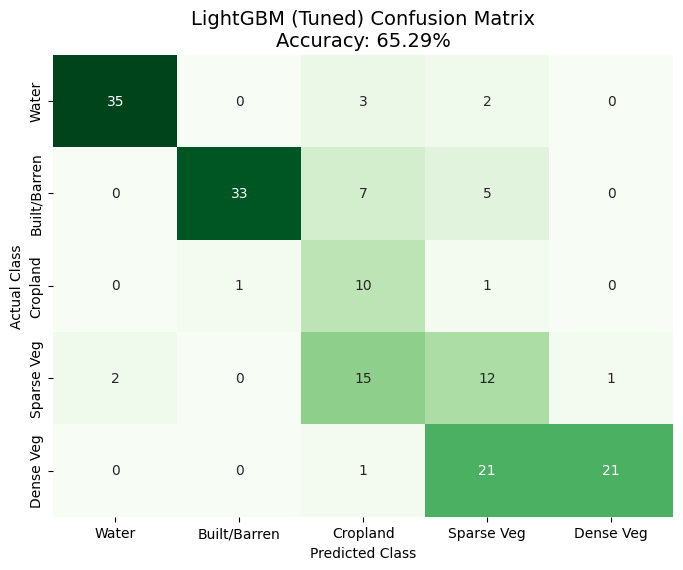

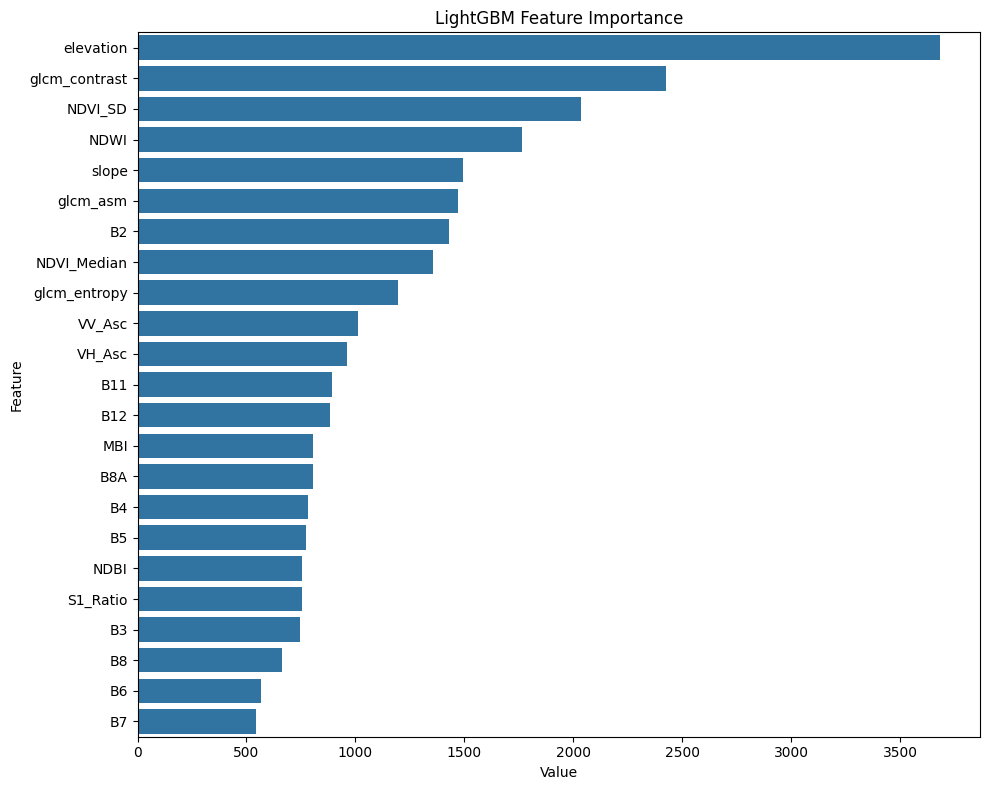

In [ ]:
import lightgbm as lgb

df_train_lgb = geemap.ee_to_df(training_points_gbt)

X_train_lgb = df_train_lgb[feature_cols].values
y_train_lgb = df_train_lgb[label].values

valid_subset_lgb = input_image.select(feature_cols).sampleRegions(
    collection=validationSet,
    properties=[label],
    scale=10,
    tileScale=16,
    geometries=False
)
df_val_lgb = geemap.ee_to_df(valid_subset_lgb)
X_val_lgb = df_val_lgb[feature_cols].values
y_val_lgb = df_val_lgb[label].values

print(f"Data Loaded. Training LightGBM on {len(X_train_lgb)} samples...")

model_lgb = lgb.LGBMClassifier(
    boosting_type='gbdt',
    n_estimators=300,
    learning_rate=0.05,
    num_leaves=20,
    max_depth=6,
    min_child_samples=20,
    reg_alpha=0.1,
    reg_lambda=0.1,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

model_lgb.fit(X_train_lgb, y_train_lgb)

y_pred_lgb = model_lgb.predict(X_val_lgb)

evaluate_model(y_val_lgb, y_pred_lgb, "LightGBM (Tuned)")

feature_imp = pd.DataFrame(sorted(zip(model_lgb.feature_importances_, feature_cols)), columns=['Value','Feature'])

print("\n")
plt.figure(figsize=(10, 8))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Feature Importance')
plt.tight_layout()
plt.show()

### 1D - CNN (Spectral)

In [ ]:
DRIVE_FOLDER = 'GEE_LULC_Project'
FILENAME = 'training_data_cnn'

feature_cols = input_image.bandNames().getInfo()
selectors = feature_cols + [label]

dataset_for_export = input_image.addBands(manual_class_image).stratifiedSample(
    numPoints=10000,
    classBand=label,
    region=aoi,
    scale=10,
    geometries=False
)

task = ee.batch.Export.table.toDrive(
    collection=dataset_for_export,
    description='Export_Training_Data_CNN',
    folder=DRIVE_FOLDER,
    fileNamePrefix=FILENAME,
    fileFormat='TFRecord',
    selectors=selectors
)

task.start()

while True:
    status = task.status()
    state = status['state']

    if state == 'COMPLETED':
        print(f"\nSUCCESS: Data exported to Drive/{DRIVE_FOLDER}/{FILENAME}.tfrecord")
        break
    elif state in ['FAILED', 'CANCELLED']:
        error_msg = status.get('error_message', 'Unknown error')
        raise RuntimeError(f"Export Failed! Status: {state}. Reason: {error_msg}")
    else:
        print(".", end="", flush=True)
        time.sleep(15)

.........
SUCCESS: Data exported to Drive/GEE_LULC_Project/training_data_cnn.tfrecord


In [ ]:
search_pattern = f'/content/drive/My Drive/{DRIVE_FOLDER}/training_data_cnn.tfrecord*'
tfrecord_files = glob.glob(search_pattern)
tfrecord_files = [f for f in tfrecord_files if '2d' not in os.path.basename(f)]

if not tfrecord_files:
    raise FileNotFoundError(f"No 1D files found. Check your Drive path.")

print(f"Found {len(tfrecord_files)} correct file(s):")
for f in tfrecord_files:
    print(f" - {os.path.basename(f)}")

def parse_tfrecord_fn(example_proto):
    feature_description = {
        col: tf.io.FixedLenFeature([], tf.float32) for col in feature_cols
    }
    feature_description[label] = tf.io.FixedLenFeature([], tf.float32)
    parsed_features = tf.io.parse_single_example(example_proto, feature_description)
    parsed_features[label] = tf.cast(parsed_features[label], tf.int64)

    return parsed_features

compression = 'GZIP' if tfrecord_files[0].endswith('.gz') else None

raw_dataset = tf.data.TFRecordDataset(tfrecord_files, compression_type=compression)
parsed_dataset = raw_dataset.map(parse_tfrecord_fn)

X_list = []
y_list = []

for features in parsed_dataset:
    record_features = [features[col].numpy() for col in feature_cols]
    record_label = features[label].numpy()
    X_list.append(record_features)
    y_list.append(record_label)

X = np.array(X_list)
y = np.array(y_list)

print(f"Shape: {X.shape}")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_cnn = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_test_cnn = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

y_train_cat = to_categorical(y_train, num_classes=5)
y_test_cat = to_categorical(y_test, num_classes=5)

Found 1 correct file(s):
 - training_data_cnn.tfrecord.gz
Shape: (50000, 23)


Epoch 1/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.7768 - loss: 0.6463 - val_accuracy: 0.8937 - val_loss: 0.2808
Epoch 2/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8674 - loss: 0.3607 - val_accuracy: 0.9072 - val_loss: 0.2486
Epoch 3/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8800 - loss: 0.3152 - val_accuracy: 0.9189 - val_loss: 0.2261
Epoch 4/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8835 - loss: 0.3024 - val_accuracy: 0.9182 - val_loss: 0.2111
Epoch 5/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8933 - loss: 0.2841 - val_accuracy: 0.9210 - val_loss: 0.2037
Epoch 6/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8952 - loss: 0.2715 - val_accuracy: 0.9259 - val_loss: 0.1962
Epoch 7/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8976 - loss: 0.2696 - val_accuracy: 0.9278 - val_loss: 0.1889
Epoch 8/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8981 - loss: 0.2603 - val_accuracy: 0

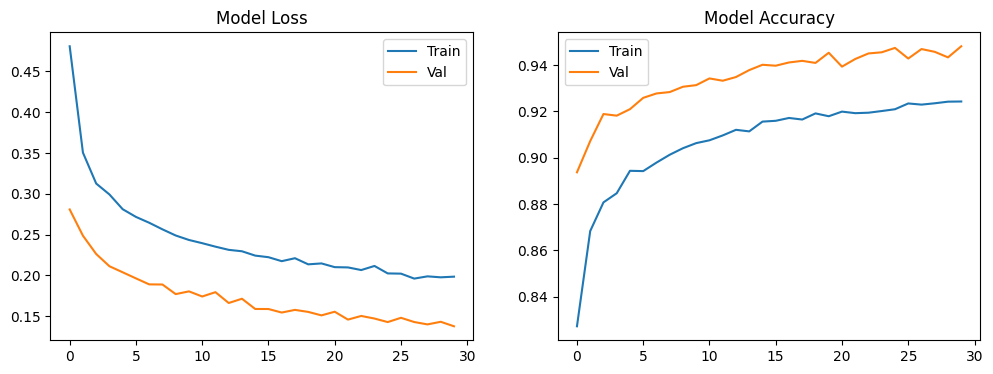

In [ ]:
from tensorflow.keras import layers, models, optimizers, callbacks

def create_1d_cnn(input_shape, num_classes):
    model = models.Sequential([

        # Layer 1: Feature Extraction
        layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape, padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling1D(pool_size=2),
        layers.Dropout(0.2),

        # Layer 2: Deeper Features
        layers.Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling1D(pool_size=2),
        layers.Dropout(0.3),

        # Classifier Head
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

cnn_model = create_1d_cnn(X_train_cnn.shape[1:], 5)

history = cnn_model.fit(
    X_train_cnn, y_train_cat,
    validation_data=(X_test_cnn, y_test_cat),
    epochs=30,
    batch_size=64,
    callbacks=[callbacks.EarlyStopping(patience=8, restore_best_weights=True)],
    verbose=1
)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title('Model Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title('Model Accuracy')
plt.legend()
plt.show()


1D-CNN (SPECTRAL) EVALUATION
Validation Points: 170
Overall Accuracy     | 65.88%
Kappa Coefficient    | 0.5720

Detailed Report:
              precision    recall  f1-score   support

       Water       0.97      0.85      0.91        40
Built/Barren       0.81      0.76      0.78        45
    Cropland       0.30      0.75      0.43        12
  Sparse Veg       0.37      0.47      0.41        30
   Dense Veg       0.84      0.49      0.62        43

    accuracy                           0.66       170
   macro avg       0.66      0.66      0.63       170
weighted avg       0.74      0.66      0.68       170



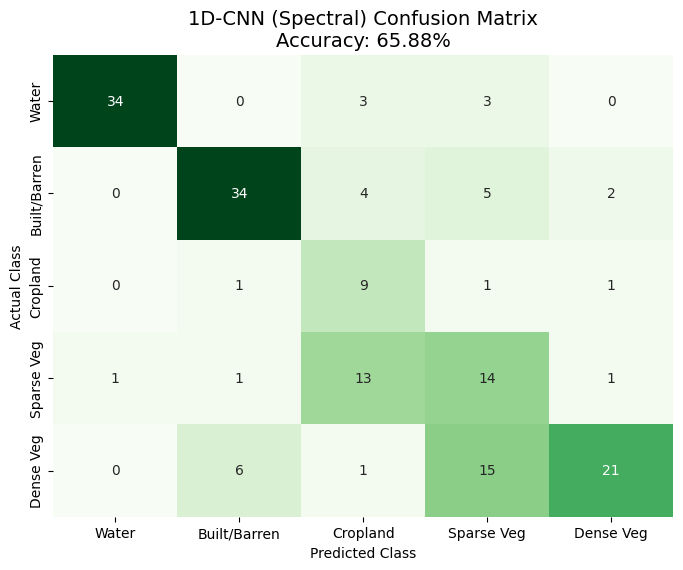

In [ ]:
valid_subset = input_image.sampleRegions(
    collection=validationSet,
    properties=[label],
    scale=10,
    tileScale=16,
    geometries=False
)
df_val_ext = geemap.ee_to_df(valid_subset).dropna()

X_ext = df_val_ext[feature_cols].values
y_ext_true = df_val_ext[label].values

X_ext_scaled = scaler.transform(X_ext)
X_ext_cnn = X_ext_scaled.reshape(X_ext_scaled.shape[0], X_ext_scaled.shape[1], 1)

y_probs_ext = cnn_model.predict(X_ext_cnn, verbose=0)
y_ext_pred = np.argmax(y_probs_ext, axis=1)

evaluate_model(y_ext_true, y_ext_pred, "1D-CNN (Spectral)")

### 2D - CNN

In [ ]:
kernel_size = 1
scale = 10
proj = 'EPSG:32643'
DRIVE_FOLDER = 'GEE_LULC_Project'
FILENAME_BASE = 'training_data_cnn_2d'

input_fixed = input_image.select(feature_cols).unmask(0).reproject(crs=proj, scale=scale)
array_image = input_fixed.neighborhoodToArray(ee.Kernel.square(radius=kernel_size))

old_names = feature_cols
new_names = [n + '_patch' for n in old_names]
array_image_renamed = array_image.select(old_names, new_names)

if 'training_points' not in locals():
    manualGeometries = ee.FeatureCollection("projects/gen-lang-client-0513989295/assets/manual_geometries")
    mask = ee.Image(0).byte().paint(manualGeometries, 1)
    lbl_img = ee.Image(0).byte().paint(manualGeometries, label).updateMask(mask).rename(label)
    training_points = lbl_img.stratifiedSample(numPoints=3000, classBand=label, region=aoi, scale=30, geometries=True)

clean_points = training_points.select([label])
points_with_random = clean_points.randomColumn('split_rand')

batches = [
    {'id': 1, 'min': 0.0, 'max': 0.34},
    {'id': 2, 'min': 0.34, 'max': 0.67},
    {'id': 3, 'min': 0.67, 'max': 1.01}
]

tasks = []
selectors = new_names + [label]

for batch in batches:
    batch_points = points_with_random.filter(
        ee.Filter.And(
            ee.Filter.gte('split_rand', batch['min']),
            ee.Filter.lt('split_rand', batch['max'])
        )
    )

    samples = array_image_renamed.sampleRegions(
        collection=batch_points,
        scale=scale,
        projection=proj,
        geometries=False,
        tileScale=16
    )

    filename = f"{FILENAME_BASE}_{batch['id']}"

    task = ee.batch.Export.table.toDrive(
        collection=samples,
        description=f'Export_2D_Batch_{batch["id"]}',
        folder=DRIVE_FOLDER,
        fileNamePrefix=filename,
        fileFormat='TFRecord',
        selectors=selectors
    )

    task.start()
    tasks.append(task)
    print(f"Task {batch['id']} started: {filename}.tfrecord")

validationSet = ee.FeatureCollection("projects/gen-lang-client-0513989295/assets/validation_results")
val_samples = array_image_renamed.sampleRegions(
    collection=validationSet,
    scale=scale,
    projection=proj,
    geometries=False,
    tileScale=16
)

val_task = ee.batch.Export.table.toDrive(
    collection=val_samples,
    description='Export_2D_Validation',
    folder=DRIVE_FOLDER,
    fileNamePrefix='validation_data_cnn_2d',
    fileFormat='TFRecord',
    selectors=selectors
)
val_task.start()
tasks.append(val_task)
print("Validation Task started: validation_data_cnn_2d.tfrecord")

while True:
    states = [t.status()['state'] for t in tasks]
    if all(s == 'COMPLETED' for s in states):
        print("\nALL EXPORTS COMPLETED SUCCESSFULLY!")
        break
    if any(s in ['FAILED', 'CANCELLED'] for s in states):
        raise RuntimeError("One or more exports failed.")
    print(f"Status: {states}", end="\r")
    time.sleep(30)

Task 1 started: training_data_cnn_2d_1.tfrecord
Task 2 started: training_data_cnn_2d_2.tfrecord
Task 3 started: training_data_cnn_2d_3.tfrecord
Validation Task started: validation_data_cnn_2d.tfrecord

ALL EXPORTS COMPLETED SUCCESSFULLY!


In [ ]:
drive.mount('/content/drive', force_remount=True)

DRIVE_FOLDER = 'GEE_LULC_Project'
TRAIN_FILE_BASE = 'training_data_cnn_2d'
VAL_FILE_BASE = 'validation_data_cnn_2d'
label = "Class"

patch_cols = [c + '_patch' for c in feature_cols]
patch_dim = 3
patch_pixels = 9

def parse_2d(example):
    desc = {col: tf.io.FixedLenFeature([patch_pixels], tf.float32) for col in patch_cols}
    desc[label] = tf.io.FixedLenFeature([], tf.float32)
    parsed = tf.io.parse_single_example(example, desc)
    parsed[label] = tf.cast(parsed[label], tf.int64)
    return parsed

def load_dataset(pattern):
    files = glob.glob(pattern)
    if not files: return None, None
    compression = 'GZIP' if files[0].endswith('.gz') else None
    ds = tf.data.TFRecordDataset(files, compression_type=compression).map(parse_2d)

    X_list, y_list = [], []
    for d in ds:
        flat_patch = tf.stack([d[c] for c in patch_cols], axis=-1)
        X_list.append(flat_patch.numpy())
        y_list.append(d[label].numpy())
    return np.array(X_list), np.array(y_list)

X_train_raw, y_train_raw = load_dataset(f'/content/drive/My Drive/{DRIVE_FOLDER}/{TRAIN_FILE_BASE}_*.tfrecord*')
X_val_raw, y_val_raw = load_dataset(f'/content/drive/My Drive/{DRIVE_FOLDER}/{VAL_FILE_BASE}*.tfrecord*')

if X_train_raw is None or X_val_raw is None:
    raise FileNotFoundError("Files not found. Ensure GEE exports are complete.")

X_train_all = X_train_raw.reshape(-1, patch_dim, patch_dim, len(feature_cols))
X_val_all = X_val_raw.reshape(-1, patch_dim, patch_dim, len(feature_cols))

X_train, X_monitor, y_train, y_monitor = train_test_split(
    X_train_all, y_train_raw, test_size=0.2, random_state=42, stratify=y_train_raw
)

scaler = StandardScaler()
N_tr, H, W, C = X_train.shape
X_train_scaled = scaler.fit_transform(X_train.reshape(-1, C)).reshape(N_tr, H, W, C)
X_monitor_scaled = scaler.transform(X_monitor.reshape(-1, C)).reshape(X_monitor.shape)
X_val_scaled = scaler.transform(X_val_all.reshape(-1, C)).reshape(X_val_all.shape)

y_train_cat = to_categorical(y_train, num_classes=5)
y_monitor_cat = to_categorical(y_monitor, num_classes=5)

Mounted at /content/drive


Epoch 1/40
1685/1685 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - accuracy: 0.8476 - loss: 0.4254 - val_accuracy: 0.9223 - val_loss: 0.2005
Epoch 2/40
1685/1685 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9145 - loss: 0.2327 - val_accuracy: 0.9372 - val_loss: 0.1655
Epoch 3/40
1685/1685 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9284 - loss: 0.1966 - val_accuracy: 0.9500 - val_loss: 0.1330
Epoch 4/40
1685/1685 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9372 - loss: 0.1739 - val_accuracy: 0.9530 - val_loss: 0.1233
Epoch 5/40
1685/1685 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9427 - loss: 0.1596 - val_accuracy: 0.9584 - val_loss: 0.1140
Epoch 6/40
1685/1685 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9478 - loss: 0.1455 - val_accuracy: 0.9562 - val_loss: 0.1125
Epoch 7/40
1685/1685 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9496 - loss: 0.1425 - val_accuracy: 0.9493 - val_loss: 0.1240
Epoch 8/40
1685/1685 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9530 - loss: 0.1343 -

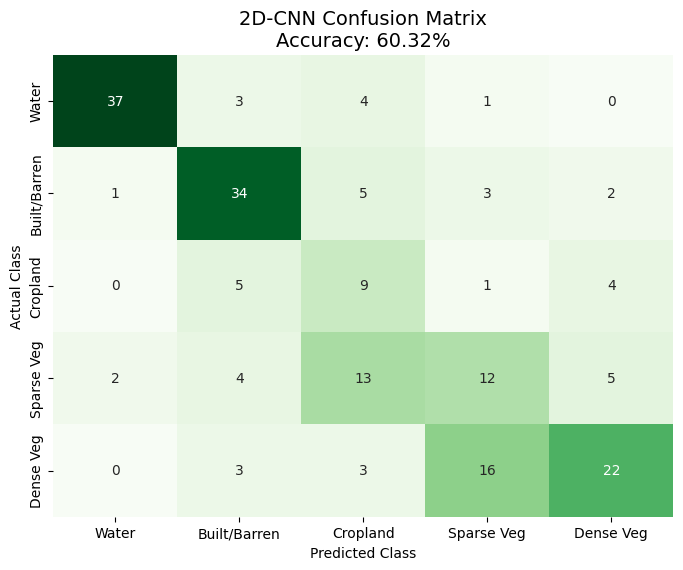

In [ ]:
from tensorflow.keras import layers, models, callbacks

def create_2d_cnn(input_shape, num_classes):
    model = models.Sequential([
        layers.Conv2D(32, (2, 2), activation='relu', padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.Conv2D(64, (2, 2), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.GlobalAveragePooling2D(),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = create_2d_cnn(X_train_scaled.shape[1:], 5)

history = model.fit(
    X_train_scaled, y_train_cat,
    validation_data=(X_monitor_scaled, y_monitor_cat),
    epochs=40,
    batch_size=64,
    callbacks=[callbacks.EarlyStopping(patience=8, restore_best_weights=True)],
    verbose=1
)

probs = model.predict(X_val_scaled)
preds = np.argmax(probs, axis=1)

evaluate_model(y_val_raw, preds, "2D-CNN")

### Maximum Likelihood Classifier (MLC)


MAXIMUM LIKELIHOOD EVALUATION
Validation Points: 170
Overall Accuracy     | 55.29%
Kappa Coefficient    | 0.4422

Detailed Report:
              precision    recall  f1-score   support

       Water       0.92      0.90      0.91        40
Built/Barren       0.92      0.76      0.83        45
    Cropland       0.29      0.42      0.34        12
  Sparse Veg       0.25      0.63      0.36        30
   Dense Veg       0.00      0.00      0.00        43

    accuracy                           0.55       170
   macro avg       0.48      0.54      0.49       170
weighted avg       0.52      0.55      0.52       170



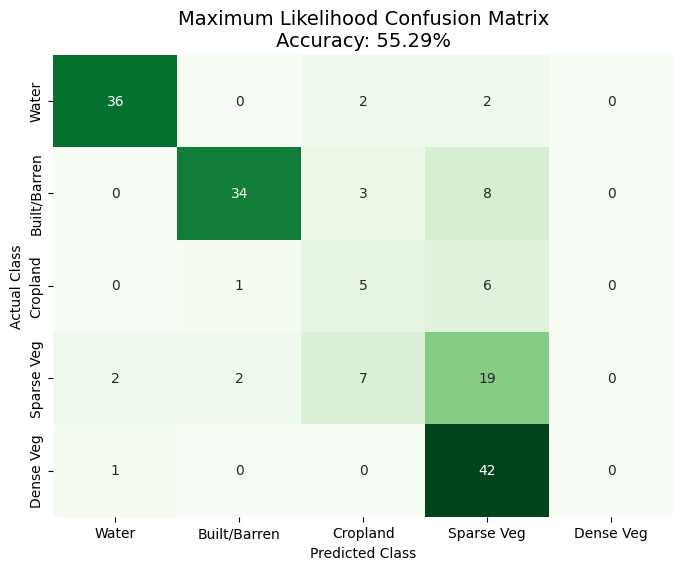

In [ ]:
mlc_classifier = ee.Classifier.minimumDistance(
    metric='mahalanobis'
).train(
    features=training_points,
    classProperty=label,
    inputProperties=feature_cols
)

classified_mlc = input_image.select(feature_cols).classify(mlc_classifier)

results_mlc = classified_mlc.sampleRegions(
    collection=validationSet,
    properties=[label],
    scale=10,
    tileScale=16,
    geometries=False
)

data_mlc = results_mlc.reduceColumns(ee.Reducer.toList().repeat(2), [label, 'classification']).getInfo()
y_true_mlc = np.array(data_mlc['list'][0])
y_pred_mlc = np.array(data_mlc['list'][1])

evaluate_model(y_true_mlc, y_pred_mlc, "Maximum Likelihood")

### LSTM

In [ ]:
proj = 'EPSG:32643'
scale = 10
DRIVE_FOLDER = 'GEE_LULC_Project'
FILENAME = 'training_lstm_ndvi_ts'
label = "Class"

def get_monthly_ndvi(month):
    start = ee.Date.fromYMD(2020, month, 1)
    end = start.advance(1, 'month')

    col = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED') \
        .filterDate(start, end) \
        .filterBounds(aoi) \
        .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 80)) \
        .map(maskS2clouds)

    process = ee.Algorithms.If(
        col.size().gt(0),
        col.median().normalizedDifference(['B8', 'B4']).rename('nd'),
        ee.Image(0).float().rename('nd')
    )

    return ee.Image(process)\
        .rename(ee.String('NDVI_').cat(ee.Number(month).format('%02d')))\
        .unmask(0) \
        .clip(aoi)

months = ee.List.sequence(1, 12)
monthly_images = ee.ImageCollection.fromImages(months.map(get_monthly_ndvi))
time_series_image = monthly_images.toBands()

time_series_fixed = time_series_image.reproject(crs=proj, scale=scale)

print(f"Bands created: {time_series_fixed.bandNames().getInfo()}")

clean_points = training_points.select([label])

samples = time_series_fixed.sampleRegions(
    collection=clean_points,
    properties=[label],
    scale=scale,
    projection=proj,
    geometries=False,
    tileScale=16
)

task = ee.batch.Export.table.toDrive(
    collection=samples,
    description='Export_LSTM_TimeSeries_Fixed',
    folder=DRIVE_FOLDER,
    fileNamePrefix=FILENAME,
    fileFormat='CSV'
)

task.start()

while True:
    status = task.status()
    state = status['state']

    if state == 'COMPLETED':
        print(f"\nSUCCESS: Data exported to Drive/{DRIVE_FOLDER}/{FILENAME}.csv")
        break
    elif state in ['FAILED', 'CANCELLED']:
        error_msg = status.get('error_message', 'Unknown error')
        raise RuntimeError(f"Export Failed! Reason: {error_msg}")
    else:
        print(f"Status: {state}...", end="\r")
        time.sleep(15)

Bands created: ['0_NDVI_01', '1_NDVI_02', '2_NDVI_03', '3_NDVI_04', '4_NDVI_05', '5_NDVI_06', '6_NDVI_07', '7_NDVI_08', '8_NDVI_09', '9_NDVI_10', '10_NDVI_11', '11_NDVI_12']

SUCCESS: Data exported to Drive/GEE_LULC_Project/training_lstm_ndvi_ts.csv


In [ ]:
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import models, layers, utils

file_path = f'/content/drive/My Drive/{DRIVE_FOLDER}/{FILENAME}.csv'

print(f"Loading {file_path}...")
df_lstm = pd.read_csv(file_path).dropna()

ts_cols = [c for c in df_lstm.columns if 'NDVI_' in c]
ts_cols.sort()

print(f"Time Steps Found: {len(ts_cols)} (Should be 12)")

X_raw = df_lstm[ts_cols].values
y_raw = df_lstm[label].values

num_samples = len(X_raw)
time_steps = 12
num_features = 1

scaler_lstm = StandardScaler()
X_scaled = scaler_lstm.fit_transform(X_raw)

X_lstm = X_scaled.reshape(num_samples, time_steps, num_features)

print(f"LSTM Input Shape: {X_lstm.shape}")

if y_raw.min() > 0: y_raw = y_raw - y_raw.min()
y_cat = utils.to_categorical(y_raw)

X_train, X_test, y_train, y_test = train_test_split(X_lstm, y_cat, test_size=0.2, random_state=42)


model_lstm = models.Sequential()

# Input Layer (12 steps, 1 feature)
model_lstm.add(layers.Input(shape=(time_steps, num_features)))

# LSTM Layer
model_lstm.add(layers.LSTM(64, return_sequences=False))
model_lstm.add(layers.Dropout(0.3))

# Classifier Head
model_lstm.add(layers.Dense(32, activation='relu'))
model_lstm.add(layers.Dense(y_cat.shape[1], activation='softmax'))

model_lstm.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model_lstm.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=32)

In [ ]:
from sklearn.preprocessing import StandardScaler

def get_monthly_ndvi(month):
    start = ee.Date.fromYMD(2020, month, 1)
    end = start.advance(1, 'month')

    col = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED') \
        .filterDate(start, end) \
        .filterBounds(aoi) \
        .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 80)) \
        .map(maskS2clouds)

    process = ee.Algorithms.If(
        col.size().gt(0),
        col.median().normalizedDifference(['B8', 'B4']).rename('nd'),
        ee.Image(0).float().rename('nd')
    )

    return ee.Image(process)\
        .rename(ee.String('NDVI_').cat(ee.Number(month).format('%02d')))\
        .unmask(0) \
        .clip(aoi)

months = ee.List.sequence(1, 12)
time_series_image = ee.ImageCollection.fromImages(months.map(get_monthly_ndvi)).toBands()
time_series_fixed = time_series_image.reproject(crs=proj, scale=scale)

val_samples = time_series_fixed.sampleRegions(
    collection=validationSet,
    properties=[label],
    scale=scale,
    projection=proj,
    geometries=False,
    tileScale=16
)

df_val_lstm = geemap.ee_to_df(val_samples)
print(f"Validation Samples: {len(df_val_lstm)}")

ts_cols_val = [c for c in df_val_lstm.columns if 'NDVI_' in c]
ts_cols_val.sort()

X_val_raw = df_val_lstm[ts_cols_val].values
y_val_true = df_val_lstm[label].values

X_val_scaled = scaler_lstm.transform(X_val_raw)

X_val_lstm = X_val_scaled.reshape(len(df_val_lstm), 12, 1)

y_val_probs = model_lstm.predict(X_val_lstm, verbose=0)
y_val_pred = np.argmax(y_val_probs, axis=1)

if y_val_true.min() > 0:
    y_val_true = y_val_true - y_val_true.min()

evaluate_model(y_val_true, y_val_pred, "LSTM (Time-Series)")

In [ ]:
import rasterio
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
import numpy as np

preview_region = aoi.centroid().buffer(4000).bounds()

output_tif_lstm = "lstm_prediction.tif"
temp_tif_ts = "lstm_input_ts.tif"

geemap.download_ee_image(
    time_series_fixed,
    filename=temp_tif_ts,
    region=preview_region,
    scale=10,
    crs="EPSG:4326"
)

with rasterio.open(temp_tif_ts) as src:
    img_data = src.read()
    profile = src.profile

    img_hw = np.moveaxis(img_data, 0, -1)
    rows, cols, bands = img_hw.shape

    pixels_flat = img_hw.reshape(-1, bands)
    valid_mask = ~np.isnan(pixels_flat).any(axis=1)
    pixels_filled = np.nan_to_num(pixels_flat)
    pixels_scaled = scaler_lstm.transform(pixels_filled)
    pixels_lstm = pixels_scaled.reshape(len(pixels_scaled), 12, 1)

    y_probs = model_lstm.predict(pixels_lstm, batch_size=4096, verbose=1)
    y_preds_flat = np.argmax(y_probs, axis=1).astype('float32')

    y_preds_flat[~valid_mask] = np.nan

    final_image = y_preds_flat.reshape(rows, cols)

    profile.update(count=1, dtype=rasterio.float32, nodata=np.nan)
    with rasterio.open(output_tif_lstm, 'w', **profile) as dst:
        dst.write(final_image, 1)

hex_colors = ['#2c7fb8', '#ffffcc', '#c2e699', '#31a354', '#006837']
class_labels = ['Water', 'Built/Barren', 'Cropland', 'Sparse Veg', 'Dense Veg']
cmap = ListedColormap(hex_colors)

plt.figure(figsize=(10, 10))
plt.imshow(final_image, cmap=cmap, vmin=0, vmax=4, interpolation='nearest')
plt.title("LSTM Classification Result (2020 Time Series)", fontsize=14)
plt.axis('off')

patches = [mpatches.Patch(color=hex_colors[i], label=class_labels[i]) for i in range(len(class_labels))]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., title="LULC Classes")

plt.tight_layout()
plt.show()

### Leaderboard

In [ ]:
leaderboard = pd.DataFrame(metrics_summary)
leaderboard = leaderboard.sort_values(by='Overall Accuracy', ascending=False)
leaderboard = leaderboard.drop_duplicates(subset=['Model'], keep='first')

print("MODEL LEADERBOARD")
print(leaderboard.to_string(index=False))

### Map

In [ ]:
rgbVis = {'min': 0.0, 'max': 0.3, 'bands': ['B4', 'B3', 'B2']}

palette = [
  '2c7fb8', # 0: Water
  'ffffcc', # 1: Built/Barren
  'c2e699', # 2: Cropland
  '31a354', # 3: Sparse Veg
  '006837', # 4: Dense Veg
];

#Palettes from https://colorbrewer2.org/#type=sequential&scheme=YlGn&n=5

classVis = {'palette': palette, 'min': 0, 'max': 4}

# ndvi_band = input_image.select('NDVI_Median').clip(aoi)
# ndviVis = {'min': 0, 'max': 0.8, 'palette': ['white','green']}

# ndwi_band = input_image.select('NDWI')
# ndwiVis = {'min': 0, 'max': 0.8, 'palette': ['white','blue']}

# ndbi_band = input_image.select('NDBI')
# ndbiVis = {'min': -0.5, 'max': 0.5, 'palette': ['white','red']}

Map.addLayer(medianImage, rgbVis, 'Sentinel 2 (2020 Median)')
# Map.addLayer(ndvi_band, ndviVis, 'NDVI')
# Map.addLayer(ndwi_band, ndwiVis, 'NDWI')
# Map.addLayer(ndbi_band, ndbiVis, 'NDBI')
# Map.addLayer(classified_kmeans_final.clip(aoi), classVis, "K-Means")
# Map.addLayer(classified_mlc.clip(aoi), classVis, "Maximum Likelihood (MLC)")
Map.addLayer(classified_rf, classVis, "RF)")
# Map.addLayer(classified_svm, classVis, 'SVM Classification')
# Map.addLayer(classified_gbt.clip(aoi), classVis, "Gradient Tree Boost")
# Map.add_raster(output_tif, layer_name="1D-CNN Prediction", **viz_params)
# Map.add_raster(output_tif_2d, layer_name="2D-CNN Prediction", **viz_params)


legend_dict = {
    'Water': '2c7fb8',
    'Built/Barren': 'ffffcc',
    'Cropland': 'c2e699',
    'Sparse Veg': '31a354',
    'Dense Veg': '006837'
}

Map.remove_legend()
Map.add_legend(legend_title='LULC Legend', legend_dict=legend_dict, position='bottomleft')

Map

HTML(value="<html>\n<body>\n  <div class='my-legend'>\n  <div class='legend-title'>Legend</div>\n  <div class=…

Map(center=[12.951425058365208, 77.59397287722686], controls=(WidgetControl(options=['position', 'transparent_…

Based on the sources provided and the specific context of Bengaluru's complex urban landscape, here are the best practices for collecting training data for your Sentinel-2 classification.

### 1. Sampling Strategy: Quality Over Quantity
Your shift from using the noisy ESA WorldCover dataset to manual points is supported by the literature. For a heterogeneous environment like Bengaluru, **manual, high-quality ground truth** is the scientific standard for high-accuracy studies (85–96%).

*   **Stratified Random Sampling:** Do not pick points randomly across the whole image, as you will get too many points for dominant classes (Built-up) and too few for rare classes (Water). Use **stratified sampling** to ensure you have a balanced number of samples for each of your five categories.
*   **Sample Size:** While you currently have ~33,000 points, successful local studies have achieved high accuracy with far fewer, carefully curated points. For example:
    *   Makandar & Kaman (2021) used **30 to 100 samples per class** for supervised classification of Vijayapura.
    *   Ganesha Raj et al. (2020) used **730 ground truth points** validated with geo-tagged field photographs for the whole BBMP area.
    *   **Recommendation:** Focus on curating a smaller set (e.g., 500–1,000 highly confident points per class) rather than thousands of noisy points.

### 2. Validation Sources (The "Ground Truth")
Since you cannot always visit the field, you must use rigorous proxies for ground truth to label your manual points.
*   **Google Earth Pro (Historical Imagery):** This is the most cited validation tool for Bengaluru studies. You must match the date of the high-resolution Google Earth image to your Sentinel-2 acquisition date.
*   **Ancillary Data:** Use OpenStreetMap (OSM) for road networks and delineating built-up boundaries, as done in the high-resolution mapping of Bengaluru by Grison et al..

### 3. Best Practices for Your 5 Specific Categories
Defining boundaries between classes is the biggest source of error. Based on Bengaluru-specific spectral characteristics:

#### **A. Water**
*   **Selection:** Easy to identify, but ensure you include both **clear water** and **turbid/eutrophic water**. Bengaluru's lakes often have high algal bloom or pollution.
*   **Tip:** Avoid edges where water mixes with land (mixels). Select points deep inside the water body.

#### **B. Built-up & Barren (Grouped)**
*   **Warning:** While you are grouping these, they are spectrally distinct. "Built-up" has high reflectance in MIR/SWIR bands and high texture, whereas "Barren" (bare soil) is smoother.
*   **Strategy:** Even if you label them as one category for the final map, **collect training points for them separately**. Train the model on "Buildings," "Roads," and "Bare Soil" individually, then merge them into your "Built_Barren" class *after* classification. This ensures the Random Forest learns the distinct spectral signature of each subtype.
*   **Bengaluru Context:** "Barren land" has nearly disappeared in Bengaluru (dropping to 488 hectares by 2023), as most of it has been converted to built-up areas. Be careful not to confuse fallow agricultural land with barren land.

#### **C. Dense Vegetation vs. Sparse Vegetation**
*   **Differentiation:** This is critical for Bengaluru.
    *   **Dense Vegetation:** Select samples from established locations like the **IISc campus, Lalbagh, Cubbon Park, and Defense lands**. These represent permanent, high-canopy tree cover.
    *   **Sparse Vegetation:** Select samples from **vacant sites, layouts, and seasonally grassy areas**. These are often ephemeral.
*   **Thresholding:** Local studies classify "Dense" as >40% canopy density and "Sparse" as <10% density.

#### **D. Cropland**
*   **Seasonality is Key:** Cropland is the most difficult class because it changes appearance (phenology) throughout the year.
*   **Best Practice:** Select training data using **multi-temporal images**. A pixel that is green in November (post-monsoon) but brown/bare in April (dry season) is likely **Cropland**. A pixel that remains green year-round is likely **Dense Vegetation** (trees/plantations).
*   **Image Date:** For Bengaluru, using images from the **dry season (January–March)** is recommended to distinguish irrigated cropland from rainfed vegetation.

### 4. Polygon vs. Point Sampling
Instead of single dots (points), consider drawing small **polygons** (e.g., a 3x3 pixel box) for your training data.
*   **Why:** Object-Based Image Analysis (OBIA) or polygon sampling captures the **texture** of the land cover (e.g., the heterogenous pattern of a slum vs. the uniform pattern of a lake), which improves accuracy over simple pixel-based spectral matching.

### Summary Checklist for Your Training Data:
1.  **Spatial Independence:** Ensure training points are spatially separated from your validation/testing points to prevent overfitting (auto-correlation).
2.  **Temporal Consistency:** Ensure your manual points correspond to the same year and season as your satellite image.
3.  **Balance:** Do not have 20,000 Built-up points and only 500 Water points. Try to keep the sample counts relatively balanced or proportional to the area.

Based on the provided literature, here is a comparative list of models used for Land Use Land Cover (LULC) classification, specifically focused on Bengaluru and similar Indian landscapes.

The models range from traditional **Machine Learning (ML)** to advanced **Deep Learning (DL)** and **Optimization Algorithms**.

### 1. Convolutional Neural Networks (CNN)
*   **Type:** Deep Learning (DL)
*   **Paper/Source:** *LULC Analysis of Green Cover Loss in Bangalore* (Mathew et al., 2024); *Deep Learning-Based Land Use and Land Cover Classification* (Pushpalatha et al., 2024).
*   **Accuracy:**
    *   **92%** overall accuracy in Bengaluru green cover analysis.
    *   **94.08%** to **95.30%** overall accuracy using LISS-III imagery for Karnataka regions.
*   **Description:** CNNs are deep learning algorithms that process imagery as "patches" rather than single pixels. They automatically learn spatial hierarchies, textures, and shapes (e.g., the rectangular shape of buildings vs. the irregular texture of trees).
*   **Setup:**
    *   Requires a training dataset of image "chips" or patches (e.g., 64x64 or 256x256 pixels) rather than single point csv files.
    *   Typically trained outside GEE (e.g., TensorFlow/PyTorch) and imported back for prediction, though recent GEE updates allow for some deep learning integration.
*   **Pros:**
    *   Highest reported accuracy for complex urban landscapes.
    *   Captures **spatial context** and texture, solving the "salt and pepper" noise issue common in pixel-based methods.
*   **Cons:**
    *   Computationally intensive.
    *   Requires significantly more training data (dense masks/labels) compared to RF.

### 2. Random Forest (RF) with Object-Based Image Analysis (OBIA)
*   **Type:** Machine Learning (ML)
*   **Paper/Source:** *Land Cover Mapping of Bengaluru's Urban and Surrounding Area...* (Grison et al., 2023).
*   **Accuracy:** **Global F1 Score of 0.82** (approx. 82-85% accuracy).
*   **Description:** Instead of classifying every single pixel, this method first segments the image into "objects" (groups of similar pixels) using an algorithm like **LargeScale MeanShift (LSMS)**. It then calculates statistics for each object (mean NDVI, texture, slope) and feeds these into the Random Forest classifier.
*   **Setup:**
    *   **Data Fusion:** Combined **Sentinel-2 (Optical)** and **Sentinel-1 (Radar)** to overcome monsoon cloud cover.
    *   **Feature Engineering:** Used Haralick Textures, NDVI, NDBI, and Radar Vegetation Index (RVI).
    *   **Selection:** Used Forward Selection to pick the top 40 most relevant features.
*   **Pros:**
    *   **Cloud-proof:** The inclusion of Radar (Sentinel-1) ensures data continuity during rainy seasons.
    *   **Reduces Noise:** OBIA prevents the speckled look of pixel-based maps.
    *   Open-source pipeline compatible with GEE.
*   **Cons:**
    *   Struggled with "mixed classes" like open forests vs. scrubland at 10m resolution.

### 3. Maximum Likelihood Classifier (MLC)
*   **Type:** Traditional Supervised Learning (Parametric)
*   **Paper/Source:** *Spatiotemporal Analysis of LULC... in Bengaluru* (Lakshmipathi et al., 2025); *LULC Study of Sentinel-2A...* (Makandar & Kaman, 2021).
*   **Accuracy:**
    *   **85.7% – 92.1%** (Kappa 0.82–0.89) for Bengaluru.
    *   **88.16%** for Vijayapura.
*   **Description:** A pixel-based method that assumes the pixel values for each class are normally distributed. It calculates the probability that a pixel belongs to a specific class.
*   **Setup:**
    *   Uses standard bands + NDVI.
    *   Trained on manual points (30–100 samples per class).
    *   Implemented in ArcGIS or GEE.
*   **Pros:**
    *   Statistically robust and standard for historical comparison.
    *   Computationally fast and simple to implement in GEE.
*   **Cons:**
    *   **"Salt and Pepper" effect:** Classifies pixels in isolation, leading to noise.
    *   Assumes normal distribution of data, which isn't always true for complex urban features.

### 4. Cuckoo Search (CS) & Particle Swarm Optimization (PSO)
*   **Type:** Meta-heuristic Optimization / Bio-inspired Algorithms
*   **Paper/Source:** *Chaotic Darwinian PSO for Satellite Image Segmentation*; *Cuckoo Search Multilevel Thresholding*.
*   **Accuracy:** Demonstrated higher Peak Signal-to-Noise Ratio (PSNR) and lower Mean Squared Error (MSE) compared to traditional genetic algorithms, though specific LULC percentages are not the primary metric.
*   **Description:** These are optimization algorithms used primarily for **Image Segmentation** (multilevel thresholding). They mimic nature (e.g., bird flocking or cuckoo breeding behavior) to find the optimal threshold values that separate different land classes (objects) in an image.
*   **Setup:**
    *   Used to optimize the segmentation step before classification.
    *   Modified versions like **Chaotic Darwinian PSO (CDPSO)** or **CSMcCulloch** are used to prevent the model from getting stuck in "local optima" (a common error where the model thinks it found the best solution but hasn't).
*   **Pros:**
    *   Superior convergence rates (finds the best solution faster).
    *   Better at handling "ambiguous regions" and weak pixel correlation common in satellite imagery.
*   **Cons:**
    *   Computationally expensive as the number of thresholds increases.
    *   Complex to implement from scratch in GEE compared to built-in RF or SVM.

### 5. Dynamic World (Near Real-Time Model)
*   **Type:** Deep Learning (FCN - Fully Convolutional Network)
*   **Paper/Source:** *Dynamic World, Near real-time global 10m land use land cover mapping*.
*   **Accuracy:** Varies by region, but acts as a global benchmark.
*   **Description:** A pre-trained deep learning model by Google/WRI available in GEE. It provides continuous probability predictions for 9 classes (Water, Trees, Built, etc.) for every Sentinel-2 image.
*   **Setup:**
    *   Already available in GEE as `GOOGLE/DYNAMICWORLD/V1`.
    *   Can be used as a "feature" input into your Random Forest model to boost accuracy.
*   **Pros:**
    *   Continuous feed (not static annual maps).
    *   Probability scores allow you to filter out "uncertain" pixels.
*   **Cons:**
    *   Global definitions may not perfectly match local Bengaluru definitions (e.g., distinguishing "Plantation" from "Forest").

### Summary Recommendation for Your Testing
To "cover all aspects" and find the highest accuracy for your project:

1.  **Baseline:** Run your current **Random Forest** (pixel-based).
2.  **Intermediate (Recommended):** Implement **OBIA + Random Forest**. Use the SNIC (Simple Non-Iterative Clustering) algorithm in GEE (easier than LSMS) to segment your image, then classify the *clusters* rather than pixels. This usually boosts accuracy from ~72% to ~82-85%.
3.  **High-End:** If you have the computational capacity, export your data and train a **U-Net or CNN** (Deep Learning). This is the only method consistently breaking the 90% accuracy barrier in recent literature for this specific region.

Based on the sources provided and your mentor's specific recommendations for time-series forecasting, here is the distinction between model **types**, **building blocks** (layers), and **specific model names** (architectures).

To clear up the confusion: **U-Net** is a specific **Model Name** (Architecture), whereas **CNN** is a **Model Type**, and **Conv2D/3D** are the **Building Blocks** (layers) used to construct them.

### 1. The Hierarchy: Types, Blocks, and Names

Think of this like building a house:
*   **Model Type (The Category):** "Residential Building" (Analogous to **CNN** or **RNN**).
*   **Building Block (The Material):** "Bricks" or "Wood" (Analogous to **Conv2D**, **LSTM cell**, **Attention mechanism**).
*   **Model Name (The Blueprint):** "Victorian Villa" or "Ranch Style" (Analogous to **U-Net**, **ResNet**, **Transformer**).

| Term | Category | Description & Role in Your Project |
| :--- | :--- | :--- |
| **CNN** (Convolutional Neural Network) | **Model Type** | A class of deep learning models designed to process grid data (images). Used for spatial pattern recognition (e.g., identifying "forest" vs. "urban" textures),. |
| **RNN** (Recurrent Neural Network) | **Model Type** | A class of models designed for sequential data (time-series). Your mentor recommended these (LSTM/GRU) for *forecasting* NDVI trends. |
| **Conv2D** | **Building Block** | A 2-Dimensional Convolutional Layer. It scans an image (spatial only) to detect edges, shapes, and textures. This is the main "brick" used to build a **U-Net** or standard **CNN**. |
| **Conv3D** | **Building Block** | A 3-Dimensional Convolutional Layer. It scans spatial images *over time* (Space + Time). Your mentor suggested this for "Spatiotemporal modeling" because it looks at how vegetation shapes change across weeks or months. |
| **ConvLSTM** | **Building Block** | A hybrid layer. It puts a Convolution (Conv2D) *inside* an LSTM cell. It remembers past vegetation states while looking at the spatial map. |
| **U-Net** | **Model Name** | A specific **CNN architecture**. It is famous for **Semantic Segmentation** (classifying every single pixel). It uses an "encoder-decoder" shape to create highly accurate maps. |
| **Transformer** | **Model Name** | A specific architecture that uses "Attention" mechanisms. Originally for text, now used for time-series NDVI forecasting as suggested by your mentor. |

---

### 2. Deep Dive into Your Specific Terms

#### **U-Net (The Architecture)**
*   **What it is:** U-Net is a specific design of a **CNN**. It is not a separate "type" from CNN; it is a *specialized* CNN.
*   **Why use it:** It is the industry standard for **Land Use Land Cover (LULC) segmentation**. If your goal is to generate a high-quality classification map (Water, Built-up, Dense, Sparse, Cropland) for a specific year (e.g., 2023), U-Net is likely superior to the time-series models your mentor listed.
*   **Relevance:** Papers like "DPPNet" focus on robust deep learning networks for land cover segmentation, which share the same goal as U-Net: pixel-level accuracy.

#### **Conv2D vs. Conv3D (The Layers)**
*   **Conv2D:** Used when analyzing a **single date** or a composite image (e.g., "Vegetation map of Jan 2023"). It treats the input as a flat image.
*   **Conv3D:** Used when analyzing a **video** or a **stack of images** (e.g., "Jan, Feb, Mar, Apr"). It treats the input as a volume (Height x Width x Time). Your mentor recommended **3D CNNs** because they can track how the "greenness" (NDVI) moves or shrinks over the months.

---

### 3. Reconciling Mentor Recommendations with U-Net

Your mentor's list focuses heavily on **Forecasting** (predicting the future) and **Anomaly Detection** (finding stress), whereas U-Net is typically used for **Mapping** (classifying what is there right now).

*   **If your goal is Mapping (Classification):**
    *   **Use:** **U-Net** or **DeepLabV3+** (Model Names).
    *   **Blocks:** Built using **Conv2D** layers.
    *   **Why:** You want to know "Is this pixel forest or city?" Sources show CNNs achieve ~92-95% accuracy for this in Bengaluru/Karnataka,.

*   **If your goal is Forecasting (Trend Analysis):**
    *   **Use:** **Transformer Encoder** or **Stacked ConvLSTM** (Model Names/Architectures).
    *   **Blocks:** Built using **LSTM**, **GRU**, or **Conv3D** layers.
    *   **Why:** You want to know "Will this pixel be green in 2025 based on the trend from 2010-2023?" Your mentor suggested **LSTM / GRU** for this exact purpose.

### Summary Recommendation
If you need to classify land cover (make a map), stick with **U-Net (a CNN architecture)**.
If you need to predict how vegetation will change in the future, use the **ConvLSTM or Transformer (RNN/Attention architectures)** suggested by your mentor.

Based on the provided sources and the specific context of Land Use Land Cover (LULC) research in Bengaluru, here are the standard stages of a research project. This workflow transitions from the initial concept to the final publication.

### Phase 1: Literature Review & Gap Identification
Before writing code, you must define *why* your research matters.
*   **Purpose:** The goal is to critically assess existing methodologies, trace their technical evolution (e.g., from pixel-based to deep learning), and identify persistent gaps.
*   **Gap Identification:** You must find what previous studies missed. For Bengaluru, common gaps identified in recent papers include:
    *   **The "Mixed Pixel" Problem:** Medium-resolution data (Landsat 30m) struggles to separate dense urban areas from bare soil.
    *   **Monsoon Cloud Cover:** Optical imagery is often unusable during the rainy season, creating data gaps that few studies address.
    *   **Inconsistent Definitions:** "Vegetation" is often grouped into a single class, failing to distinguish between parks, scrubland, and forests.
*   **Outcome:** Your project positioning. For example, proposing a "methodological synthesis" of CNNs with Radar data to solve the cloud issue.

### Phase 2: Study Area Definition & Data Collection
*   **Study Area:** Define the boundaries clearly (e.g., BBMP administrative boundary vs. Bengaluru Metropolitan Region) and describe the topography and climate (e.g., tropical savanna, distinct dry/wet seasons).
*   **Satellite Data Acquisition:**
    *   **Optical:** Sentinel-2 (10m) or Landsat-8 (30m) for spectral data. Recent studies emphasize using "Harmonized" Level-2A products to avoid manual atmospheric correction.
    *   **Radar (SAR):** Sentinel-1 is increasingly used to bypass cloud cover issues during the monsoon.
    *   **Ancillary Data:** Digital Elevation Models (DEM) like Cartosat-1 or SRTM to derive slope, and OpenStreetMap (OSM) for road networks.
*   **Ground Truth Collection:**
    *   **Field Surveys:** The "gold standard" involves collecting geo-tagged photographs of specific sites (e.g., 730 points covering diverse niches).
    *   **Virtual Validation:** Due to logistics, most researchers use **Google Earth Pro historical imagery** to virtually validate sample points, noting the lack of in-field data as a limitation.

### Phase 3: Methodology & Model Implementation
This is the technical core where you implement Random Forest, U-Net, or Hybrid models.
*   **Preprocessing:**
    *   **Cloud Masking:** Removing cloudy pixels using QA bands (like QA60 in Sentinel-2).
    *   **Indices Calculation:** Generating features like NDVI (Vegetation), NDBI (Built-up), and SWIR-based indices.
    *   **Texture Analysis:** Calculating Haralick Textures (entropy, correlation) to help the model distinguish between spectrally similar classes (e.g., differentiating a slum from a rocky area).
*   **Segmentation (Optional/Advanced):** If using Object-Based Image Analysis (OBIA), you group pixels into "segments" or "objects" before classification using algorithms like **Large Scale Mean Shift (LSMS)**.
*   **Model Training:**
    *   **Split Strategy:** Strictly split data into **Training** (e.g., 70%) and **Validation** (e.g., 30%) to prevent data leakage.
    *   **Algorithm Selection:**
        *   **Random Forest:** Selected for high accuracy with tabular features.
        *   **CNN/Deep Learning:** Requires exporting image "patches" (chips) rather than points to learn spatial context.
        *   **Optimization:** Some studies use algorithms like **Particle Swarm Optimization (PSO)** or **Cuckoo Search** to find optimal thresholds for segmentation.

### Phase 4: Accuracy Assessment & Validation
You must prove your map is accurate using data the model has *never* seen.
*   **Confusion Matrix:** Calculate the **Overall Accuracy** (OA) and **Kappa Coefficient**. For Bengaluru studies, an OA of **85%–92%** and Kappa > 0.82 is the standard for high-quality research.
*   **Class-Specific Metrics:**
    *   **Producer’s Accuracy (Recall):** Measures omission error (did you miss any forests?).
    *   **User’s Accuracy (Precision):** Measures commission error (did you falsely classify grass as forest?).
    *   **F1 Score:** The harmonic mean of precision and recall, crucial for unbalanced classes.
*   **Cross-Validation:** Using **Stratified K-Fold Cross-Validation** (e.g., 5-fold) is recommended to ensure the model isn't just memorizing one specific subset of data.

### Phase 5: Change Detection & Time Series Analysis
*   **Post-Classification Comparison (PCC):** Compare the LULC maps from different years (e.g., 1990 vs. 2023) to quantify transitions.
    *   *Example Finding:* "Built-up area increased sevenfold at the expense of vegetation (-24.3%)".
*   **Time Series Trend Analysis:**
    *   **NDVI Trends:** Using MODIS or Landsat composites to track the "browning" or "greening" of the city over 20+ years.
    *   **Forecasting:** Using models like **CA-Markov** or **LSTMs** to predict future land use for years like 2030 or 2050 based on historical growth patterns.

### Phase 6: Writing the Research Paper
The final output follows a rigid structure based on the "Architecture of the Literature Review" and standard scientific reporting:
1.  **Introduction:** Define the problem (urbanization in Bengaluru) and the research gap.
2.  **Materials & Methods:** Detailed description of data sources (sensors, dates) and algorithms (RF parameters, software used) so it is reproducible.
3.  **Results:** Present the maps, the statistical area changes (tables of hectares lost/gained), and the accuracy assessment tables.
4.  **Discussion:** Interpret the results.
    *   *Drivers:* Link changes to economic factors (e.g., IT corridors, ring roads).
    *   *Implications:* Discuss environmental impacts like Urban Heat Island (UHI) or groundwater depletion.
    *   *Limitations:* Be honest about errors (e.g., confusion between fallow land and built-up areas).
5.  **Conclusion:** Summarize the main findings and offer policy recommendations (e.g., "stricter land-use regulations").

Based on the most recent literature for Bengaluru (2020–2025) and the technical capabilities of Sentinel-2, your current five classes are a strong foundation, but **splitting "Built_Barren" into two separate classes** is strongly recommended to improve model accuracy and training ease.

Here is the optimal classification scheme for your project, designed to balance **accuracy** with **ease of training** in Google Earth Engine.

### 1. The Optimal 6-Class Schema
For the best results with Random Forest or U-Net on Sentinel-2 data, you should adopt these distinct spectral categories:

| Class Name | Definition & Bengaluru Context | Why this helps Accuracy? |
| :--- | :--- | :--- |
| **1. Water Bodies** | Lakes, tanks, and reservoirs. | High absorptivity in NIR/SWIR makes this easy to segregate. |
| **2. Built-up Area** | Residential layouts, commercial buildings, roads, industrial sheds, and concrete surfaces. | Distinct high reflectance in SWIR. Merging this with soil confuses the model. |
| **3. Barren/Fallow Land** | **New Class.** Open grounds, construction sites, and *fallow* agricultural land. | Spectrally distinct from concrete. Training on "Built+Barren" creates a "dirty" spectral signature, lowering accuracy. |
| **4. Dense Vegetation** | Tree canopy density >40%. Includes IISc campus, Lalbagh, Cubbon Park, and defence lands. | Essential for tracking the "Garden City" status and green cover loss. |
| **5. Sparse Vegetation** | Canopy density 10%–40%. Includes scrubland, vacant layouts with weeds, and parks. | Separates permanent trees from ephemeral grass, a key distinction in Bengaluru studies. |
| **6. Cropland** | Agricultural fields (mostly in peri-urban areas like Anekal or Devanahalli). | Distinct phenology (seasonal greening/browning) compared to permanent vegetation. |

---

### 2. Justification for these Changes

#### A. Why you MUST split "Built_Barren"
While you might want to map them together for the final output, **you must train them separately**.
*   **Spectral Confusion:** "Built-up" (concrete/asphalt) and "Barren" (soil) have different spectral signatures. Concrete reflects highly in all bands, while soil varies based on moisture. If you group them as one class during training, your Random Forest model receives conflicting data for a single label, increasing the "noise" and lowering accuracy.
*   **Trend Analysis:** In Bengaluru, "Barren Land" has drastically decreased (from 212,109 ha in 1990 to just 488 ha in 2023) as it converts to "Built-up". Tracking this conversion is a critical finding for your landscape change analysis.

#### B. The "Vegetation" Breakdown (Dense vs. Sparse vs. Crop)
Bengaluru studies specifically struggle with defining "Vegetation."
*   **Dense vs. Sparse:** Local studies explicitly use a 40% canopy threshold. "Sparse vegetation" often represents seasonal grasses on vacant plots or layouts awaiting construction. Distinguishing this from "Dense" trees allows you to report if the city is losing *trees* (permanent loss) or just *grass* (seasonal change).
*   **The Cropland Challenge:** Cropland is the hardest class because it looks like bare soil in summer and vegetation in the monsoon. Recent studies note that separating "Cropland" from "Plantation/Forest" is vital because agricultural land is the primary victim of urban expansion in the periphery.

#### C. Handling "Flooded Vegetation"
Some high-accuracy studies (Lakshmipathi et al., 2025) include **Flooded Vegetation** (wetlands) as a 7th class.
*   **Recommendation:** Unless your study specifically focuses on wetland encroachment, **exclude this class** or merge it into "Sparse Vegetation" or "Water." It covers a tiny fraction of the area (<1%) and is difficult to classify without hyperspectral data, often leading to high error rates.

### 3. Training Strategy for "Easier Training"

To make the model learn faster and more accurately:
1.  **Collect Separate Samples:** Mark points for "Red Roofs/Concrete" (Built-up) separately from "Brown Earth/Playgrounds" (Barren).
2.  **Train on 6 Classes:** Feed these 6 distinct classes into the Random Forest classifier.
3.  **Merge Post-Classification:** If your final analysis only requires 5 categories, use GEE code to merge them *after* the prediction is done:
    ```javascript
    // Remap class 3 (Barren) into class 2 (Built-up) if desired for final map
    var finalMap = classifiedImage.remap(,);
    ```
    This "Split-Train-Merge" approach consistently yields higher accuracy than training on mixed classes.

### Summary
For the **best accuracy** and **study relevance** in Bengaluru:
*   **Adopt 6 Classes:** Water, Built-up, Barren, Dense Veg, Sparse Veg, Cropland.
*   **Focus on the Built/Barren Split:** This is where the most significant land transformation in Bengaluru is happening.
*   **Use Density for Vegetation:** It provides a more nuanced analysis of environmental degradation than a single "Green" class.

Based on the provided sources, researchers analyzing Land Use Land Cover (LULC) in Bengaluru and similar contexts do not typically rely on a simple random "80:20 split" of a single dataset. Instead, they use more robust strategies like **Stratified K-Fold Cross-Validation** or **Independent Post-Classification Assessment** to ensure the model isn't just memorizing data.

Here are the specific strategies identified in the literature:

### 1. Stratified K-Fold Cross-Validation (The Machine Learning Standard)
For advanced machine learning models (like Random Forest or SVM) applied to Bengaluru, researchers use **stratified fivefold cross-validation** rather than a single static split.
*   **How it works:** The data is split into five parts. The model is trained five separate times. In each "fold," it trains on 80% of the data and tests on the remaining 20%. The final accuracy is the mean of these five runs.
*   **Why use it:** This ensures that the training and testing sets maintain the same proportions of classes (stratified sampling) as the original data. It proves the model is stable and not biased by a "lucky" random split.
*   **Source:** Grison et al. (2023) used this method for their high-resolution Bengaluru land cover map,.

### 2. Independent Post-Classification Assessment (The Remote Sensing Standard)
Many studies, particularly those using Maximum Likelihood or standard Random Forest workflows, treat accuracy assessment as a completely separate phase from training. They do not just "split" a file; they collect **independent reference data**.
*   **Training Set:** Selected based on high-resolution reference imagery to teach the classifier.
*   **Validation/Accuracy Set:** A separate set of "ground truth" points (often 30–100 samples per class or probability-based random blocks) is collected *independently*. This data is never seen by the model during the training phase,.
*   **Tools:** Researchers frequently use **Google Earth Pro historical imagery** and field surveys as the "ground truth" to validate the final map,,.
*   **Source:** Lakshmipathi et al. (2025) and Makandar & Kaman (2021) utilized this post-classification comparison method,.

### 3. Stratified Random Sampling (Addressing Class Imbalance)
To avoid accuracy bias (where a model looks accurate just because it correctly identifies the dominant "Urban" class but fails at "Water"), researchers use **stratified random sampling**.
*   **Strategy:** The study area is divided into strata (e.g., biomes or expected classes), and random samples are drawn from *each* stratum to ensure rare classes are represented in the accuracy assessment.
*   **Example:** Gong et al. (2013) collected 91,433 training samples and a totally separate set of 38,664 test samples located at preset, fixed locations using a systematic unaligned sampling strategy.

### Summary of Metrics Used
Regardless of the split strategy, the sources validate their models using these specific metrics:
*   **Overall Accuracy (OA):** The percentage of correctly classified pixels.
*   **Kappa Coefficient:** Measures agreement while accounting for chance; values >0.80 are considered reliable for Bengaluru studies,.
*   **F1 Score:** Used in machine learning approaches to balance Precision (user's accuracy) and Recall (producer's accuracy), particularly useful when class sizes are unbalanced,.

**Recommendation for your project:**
Your mentor's suggestion of a **Train/Validation/Test** split is aligned with the "Cross-Validation" approach mentioned in source. If you cannot implement full k-fold cross-validation in GEE, the standard practice is to use **Independent Validation** where your "Testing" points are spatially distinct from your "Training" points to prove your 87% accuracy is real and not a result of spatial autocorrelation.